# VT2

In [1]:
# Import of Packages
import numpy as np
import time

# Importing the Functions File
import Functions_VT2 as fn

# Start of Timer to Measure Runtime
start_time = time.time()

## Scenario Generation
Parameters

In [2]:
Param = {
    "Dt0": 22561132,  # Demand at t0
    "dt": 1,  # Steptime in Years
    "Fth": 20,  # Time Horizon of Forecasts in Steptime
    "Forecasts": 2000,  # Number of Forecasts
    "mu": 0.042754330256447565,
    "sigma": 0.05813761525452841,
    "r_D": 0.1,  # Revenues per Unit of Demand per Period
    "r_K": 1,  # Revenues per Unit of Capacity per Period
    "r_K_rent": 0.1,  # Rental Revenues per Unit of Capacity per Period
    "co_K": 0.34,  # Operational costs per unit of capacity per period
    "co_D": 0.1,  # Operational cost per unit of demand per period
    "ci_K": 7.5,  # Installation cost per unit of capacity
    "discount": 0.05,  # Discount factor
    "EoS": 0.9,  # EoS factor
    "delta_K0": 0,  # Initial Value for delta_K
    "h": 1,  # hour
    "K0": 25000000,  # Initial Capacity
    "allowed_values": np.array(
        [0, 4000000, 6000000, 8000000, 10000000]
    ),  # Capacity Increase Limit
    "population": 1000,  # Size of the Population for the GA
    "p_dock": 0.7,  # Percentage of Pax using Dock Stands rather than Bus Gates
    "p_schengen": 0.7,  # Percentage of Pax travelling within Schengen Area
    "p_Dok_A_B": 0.5,  # Percentage of Pax travelling from Dock A
    "PAXATM": 150,  # Average number of passengers carried per air traffic movement
    "DHL_factor_20": 0.0003,  # Factor to calculate the Demand Hour
    "lower_theta": 6000000,  # Lower boundary for capacity increase value
    "upper_theta": 8000000,  # Upper boundary for capacity increase value
    "stepsize_theta": 10000,  # Stepsize for capacity increase value
    "lower_cond": -15000000,  # Lower boundary for capacity increase condition
    "upper_cond": -1000000,  # Upper boundary for capacity increase condition
    "stepsize_cond": 50000,  # Stepsize for capacity increase condition
}

## Creating Scenarios

In [3]:
# Calling the Scenario Creation function
Scenarios = fn.Generate_scenarios(Param)
# Round values up for further calculation
Demand = np.ceil(Scenarios)

Geometric Brownian motion Formula

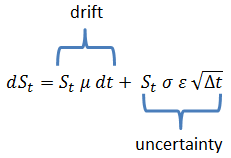

## Optimization of the ENPV with a GA

Genetic Algorithm

In [4]:
# Calculating the optimal delta_K vector with the genetic algorithm
delta_K_optimized = fn.GA(Param, Demand, 0)

print("Best delta_K:", delta_K_optimized / 1000000)
print("Best ENPV:", delta_K_optimized.fitness.values[0])

Best delta_K: [ 0.  0.  6.  4.  0.  0. 10.  0.  0.  6.  0.  0.  0.  4.  0.  0.  0.  0.
  0.  0.]
Best ENPV: 288822802.0002899


Using the optimal delta_K to calculate the optimal Capacity, the NPVs and the ENPV

In [5]:
# Calculating the Capacity Matrix with the optimal delta_K vector
K_Optimized = fn.Capacity(delta_K_optimized, Param)

# Calculating the NPV and ENPV
NPV_Optimized = fn.NPV_calculation(K_Optimized, Demand, delta_K_optimized, Param, 0)
ENPV_Optimized = np.mean(NPV_Optimized)

# Creating a Matrix with the Demand and the Capacity Matrix for plotting
K_Optimized_with_Demand_Plot = np.vstack([Demand, K_Optimized])

### Plot of the Optimization Results

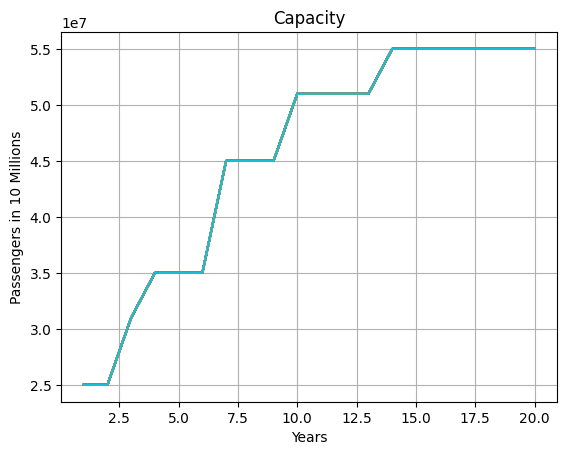

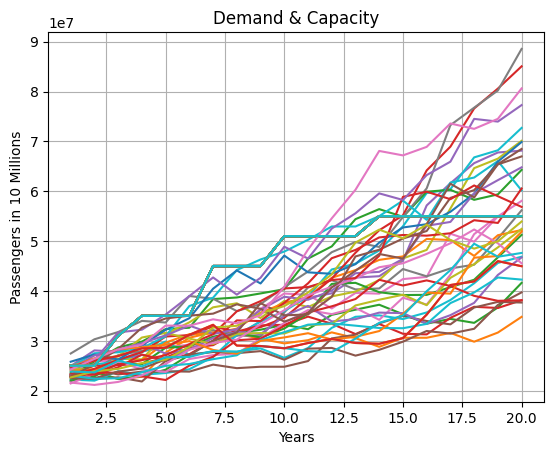

<Figure size 640x480 with 0 Axes>

In [6]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    K_Optimized,
    Param["Fth"],
    True,
    "Capacity",
    "Passengers in 10 Millions",
    30,
)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    K_Optimized_with_Demand_Plot,
    Param["Fth"],
    True,
    "Demand & Capacity",
    "Passengers in 10 Millions",
    80,
)

## Optimization of the Decision Rule

Finding the Optimal Capacity increase value with the optimal Capacity increase condition

In [7]:
# Calling the Evaluation function to calculate the optimal theta and condition
ENPV_Flex, theta, condition_flex = fn.Evaluation(Param, Demand, 1000)

print("Maximum ENPV:", ENPV_Flex)
print("Optimal theta:", theta)
print("Optimal condition:", condition_flex)

Maximum ENPV: 314382407.43215644
Optimal theta: 7050000
Optimal condition: -14950000


Calculating the ENPV for the Flexible Case

In [8]:
# Calculating the optimal delta_K vector with the Decision Rule
delta_K_Flex = fn.Decision_Rule(Param["K0"], Demand, theta, condition_flex)

# Calculating the Capacity Matrix with the delta_K vector from the Decision Rule
K_Flex = fn.Capacity2(Param["K0"], delta_K_Flex)

# Calculating the NPV
NPV_Flex = fn.NPV_Flexible(delta_K_Flex, Param, Demand, condition_flex)

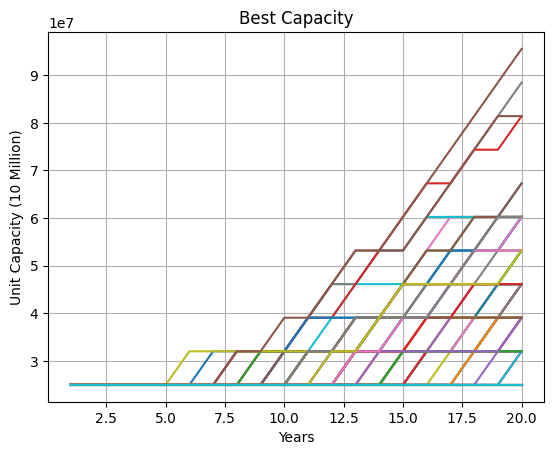

<Figure size 640x480 with 0 Axes>

In [9]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    K_Flex,
    Param["Fth"],
    True,
    "Best Capacity",
    "Unit Capacity (10 Million)",
    80,
)

## Target Curves

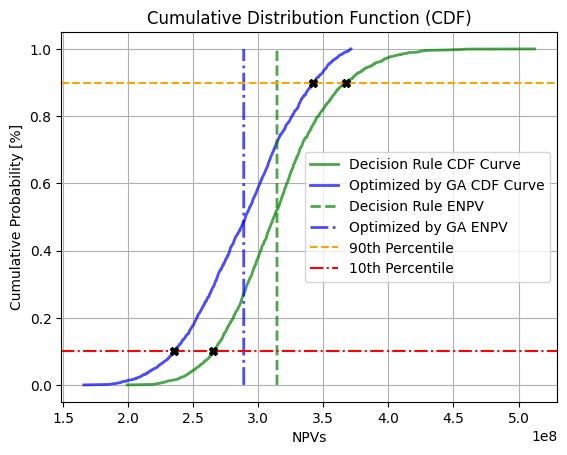

10th Percentile Decision Rule: 265240463.4265159
90th Percentile Decision Rule: 367693736.4222134
10th Percentile Optimized by GA: 235214484.57684302
90th Percentile Optimized by GA: 342266453.06416935
ENPV Decision Rule: 314382407.43215644
ENPV Optimized by GA: 288822802.0002899
ENPV_Decision_Rule / ENPV_Optimized: 8.8496 %


In [10]:
# Target Curves
Percentiles = fn.CDF_Plot(
    NPV_Flex,
    NPV_Optimized,
    "Decision Rule",
    "Optimized by GA",
)

# Percentiles
print("10th Percentile Decision Rule:", Percentiles[0])
print("90th Percentile Decision Rule:", Percentiles[1])
print("10th Percentile Optimized by GA:", Percentiles[2])
print("90th Percentile Optimized by GA:", Percentiles[3])

print("ENPV Decision Rule:", ENPV_Flex)
print("ENPV Optimized by GA:", ENPV_Optimized)
print(
    "ENPV_Decision_Rule / ENPV_Optimized:",
    np.round(((ENPV_Flex / ENPV_Optimized) - 1) * 100, 4),
    "%",
)

## Calculation of Dockstand Demand

Calcualtion of the Desing Hour Load (DHL) and Docking Stand Demand

In [11]:
# Contact Stand Demand (ZRH has 75, but not all can be used at once)
# Dock A has 17 Contact and 16 Bus Gates

No_Docks = fn.Dockstands(K_Optimized, Param)
print("Contactstand demad:\n", No_Docks[0])

No_Docks_Flex = fn.Dockstands(K_Flex, Param)
print("Contactstand demad in the Flexible Case:\n", No_Docks_Flex)

Contactstand demad:
 [13. 13. 16. 18. 18. 18. 23. 23. 23. 25. 25. 25. 25. 27. 27. 27. 27. 27.
 27. 27.]
Contactstand demad in the Flexible Case:
 [[13. 13. 13. ... 16. 16. 16.]
 [13. 13. 13. ... 16. 16. 20.]
 [13. 13. 13. ... 23. 27. 27.]
 ...
 [13. 13. 13. ... 20. 20. 20.]
 [13. 13. 13. ... 13. 16. 16.]
 [13. 13. 13. ... 23. 27. 27.]]


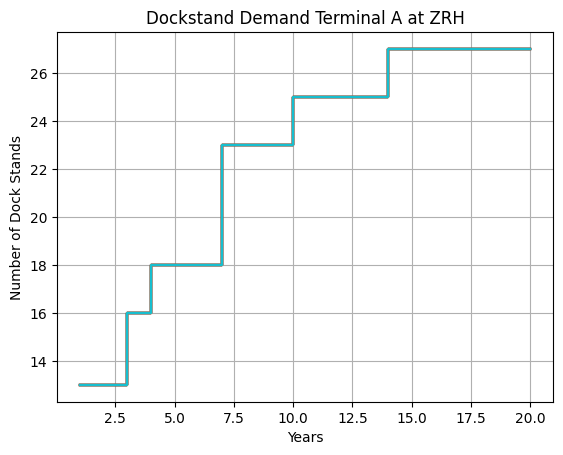

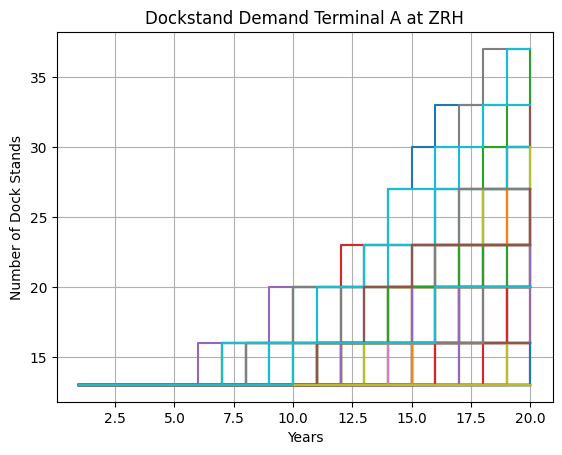

<Figure size 640x480 with 0 Axes>

In [12]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    No_Docks,
    Param["Fth"],
    False,
    "Dockstand Demand Terminal A at ZRH",
    "Number of Dock Stands",
    30,
)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    No_Docks_Flex,
    Param["Fth"],
    False,
    "Dockstand Demand Terminal A at ZRH",
    "Number of Dock Stands",
    100,
)

### Stopping the Runtime

In [13]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime =", round(total_run_time, 2), "s")

Total Runtime = 24.61 s
